In [70]:
import csv
import numpy as np
from scipy.optimize import fmin, minimize

In [48]:
qlist = []
xlist = []
with open('measurements.csv', 'r') as f:
    reader = csv.reader(f, quoting=csv.QUOTE_NONNUMERIC)
    try:
        next(reader)
    except ValueError:
        pass
    for line in reader:
        qlist.append(line[1:4])
        xlist.append(line[4:])

q = np.array(qlist, dtype=np.float32)
x = np.array(xlist, dtype=np.float32)

In [85]:
# q = np.array(shape=(N, 3))

z = np.zeros((q.shape[0], 3), dtype=np.float32)
z[:, -1] += 1.0

c1 = np.cos(q[:, 0])
c2 = np.cos(q[:, 1])
s1 = np.sin(q[:, 0])
s2 = np.sin(q[:, 1])
c23 = np.cos(q[:, 1] + q[:, 2])
s23 = np.sin(q[:, 1] + q[:, 2])

v1 = np.stack((c1 * c2, s1 * c2, s2), axis=1)
v2 = np.stack((c1 * c23, s1 * c23, s23), axis=1)

# qmat.shape == (N, 3, )3
qmat = np.stack((z, v1, v2), axis=2)

    
def f(l, qmat, x):
    # Will also work with l (no tile, automatically broadcast) and then no need to squeeze fk below
    l_arr = np.expand_dims(np.tile(l, (qmat.shape[0], 1)), -1)
    fk = np.matmul(qmat, l_arr)
    targ = fk.squeeze() - x
    return np.sum(targ * targ)
    


In [62]:
np.tile(np.array((2., 2., 2.)), (qmat.shape[0], 1)).shape

(27, 3)

In [86]:
l0 = np.array((2.0, 2.0, 2.0))

val_list = []

def cb(lk):
    val_list.append(f(lk, qmat, x))
    
res = fmin(f, l0, args=(qmat, x), ftol=0.000000001, callback=cb)
# res = minimize(f, l0, args=(qmat, x), callback=cb)

Optimization terminated successfully.
         Current function value: 0.057758
         Iterations: 60
         Function evaluations: 109


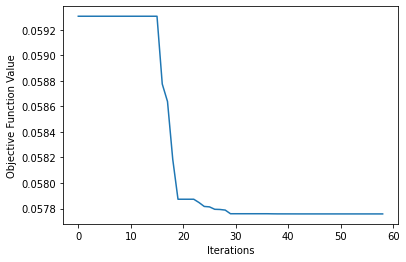

In [87]:
import matplotlib.pyplot as plt

plt.plot(val_list)
ax = plt.gca()
ax.set_xlabel('Iterations')
ax.set_ylabel('Objective Function Value')
plt.show()

In [88]:
mse0 = f(l0, qmat, x) / qmat.shape[0]
msef = f(res, qmat, x) / qmat.shape[0]
print(f'MSE before optimization (l = {l0}) is {mse0}')
print(f'MSE after optimization (l = {res}) is {msef}')

MSE before optimization (l = [2. 2. 2.]) is 0.002196531178641651
MSE after optimization (l = [1.99560506 1.99486633 2.00341869]) is 0.0021391797890890326
